
# QAOA



## Problem Formulation


In [3]:
from qiskit import Aer, QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from math import pi

backend = Aer.get_backend('unitary_simulator')

# Create a quantum circuit with one qubit
qc = QuantumCircuit(2)

qc.rzz(pi, 0,1)
result = execute(qc,backend).result()

print(result.get_unitary(qc,2).data)
#CAPTION Show the matrix of the rzz gate

[[0.-1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]]


In [5]:
qc = QuantumCircuit(2)
qc.rzz(-pi, 0,1)
result = execute(qc,backend).result()
print(result.get_unitary(qc,2).data)
#CAPTION Show the matrix of the rzz gate with flipped theta

[[0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+1.j]]


In [6]:
qc = QuantumCircuit(2)
qc.crz(-pi, 0,1)
result = execute(qc,backend).result()
print(result.get_unitary(qc,2).data)
#CAPTION Show the matrix of the rzz gate with flipped theta

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]]


In [7]:
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.rz(-pi, 1)
qc.cx(0,1)
result = execute(qc,backend).result()
print(result.get_unitary(qc,2).data)
#CAPTION Calculate the tensor product using a quantum circuit

[[0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+1.j]]


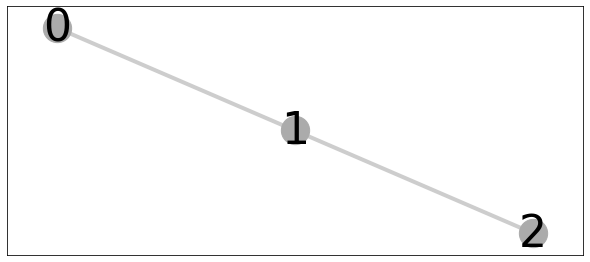

In [9]:
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2])
graph.add_edges_from([(0, 1), (1, 2)])
#nx.draw(graph, with_labels=True, alpha=0.8, node_size=1500)
#CAPTION Draw the simple graph

plt.figure(1,figsize=(8,2.5)) 
plt.tight_layout()
plt.subplots_adjust(bottom=-.5, right=0.5, left=-.5)
#print(ax)
#def nudge(pos, x_shift, y_shift):
#    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

pos = nx.spring_layout(graph)

nx.draw_networkx_nodes(graph, pos=pos, node_color="#ABABAB", node_size=800)   # default nodes and edges
nx.draw_networkx_edges(graph, pos, width=4, edge_color ="#CDCDCD")
labels=nx.draw_networkx_labels(graph,pos=pos, font_color="#000", font_size=44)
plt.show()

In [11]:
from qiskit.circuit import Parameter

def problem_circuit(graph, gamma):
    
    qc_p = QuantumCircuit(len(graph.nodes()))
    for edge in list(graph.edges()):
        qc_p.rzz(gamma, edge[0], edge[1])
        qc_p.barrier()
    
    return qc_p

gamma = Parameter("gamma")
qc_p = problem_circuit(graph, gamma)
qc_p.draw()
#CAPTION The problem formulation

░              ░ 
q_0: ─■───────────░──────────────░─
      │ZZ(gamma)  ░              ░ 
q_1: ─■───────────░──■───────────░─
                  ░  │ZZ(gamma)  ░ 
q_2: ─────────────░──■───────────░─
                  ░              ░

## The Ansatz 


In [12]:
def ansatz_circuit(graph, beta):
    qc_a = QuantumCircuit(len(graph.nodes()))
    for i in range(len(graph.nodes())):
        qc_a.rx(beta, i)
    
    return qc_a

beta = Parameter("beta")
ansatz_circuit(graph, beta).draw()
#CAPTION The ansatz

┌──────────┐
q_0: ┤ Rx(beta) ├
     ├──────────┤
q_1: ┤ Rx(beta) ├
     ├──────────┤
q_2: ┤ Rx(beta) ├
     └──────────┘

## Trial state and QAOA Process



In [13]:
def get_circuit(graph, beta, gamma):
    cnt_qubits = len(graph.nodes())
    qc_qaoa = QuantumCircuit(cnt_qubits)

    # initial_state
    qc_qaoa.h(range(cnt_qubits))
    
    # append problem circuit
    qc_qaoa.append(problem_circuit(graph, gamma), range(cnt_qubits))
    
    # append ansatz circuit
    qc_qaoa.append(ansatz_circuit(graph, beta), range(cnt_qubits))

    qc_qaoa.measure_all()
    return qc_qaoa

beta = Parameter("beta")
gamma = Parameter("gamma")
get_circuit(graph, beta, gamma).decompose().draw()
#CAPTION The full QAOA circuit

┌─────────┐             ░              ░ ┌──────────┐ ░ ┌─┐      
   q_0: ┤ U2(0,π) ├─■───────────░──────────────░─┤ Rx(beta) ├─░─┤M├──────
        ├─────────┤ │ZZ(gamma)  ░              ░ ├──────────┤ ░ └╥┘┌─┐   
   q_1: ┤ U2(0,π) ├─■───────────░──■───────────░─┤ Rx(beta) ├─░──╫─┤M├───
        ├─────────┤             ░  │ZZ(gamma)  ░ ├──────────┤ ░  ║ └╥┘┌─┐
   q_2: ┤ U2(0,π) ├─────────────░──■───────────░─┤ Rx(beta) ├─░──╫──╫─┤M├
        └─────────┘             ░              ░ └──────────┘ ░  ║  ║ └╥┘
meas_0: ═════════════════════════════════════════════════════════╩══╬══╬═
                                                                    ║  ║ 
meas_1: ════════════════════════════════════════════════════════════╩══╬═
                                                                       ║ 
meas_2: ═══════════════════════════════════════════════════════════════╩═

In [14]:
def get_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for solution, count in counts.items():
        performance = 0
        for i, j in graph.edges():
            if solution[i] != solution[j]:
                performance -= 1

        avg += performance * count
        sum_count += count
    return avg/sum_count
#CAPTION Calculate the expectation value

In [15]:
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

def calculate_circ(graph, beta, gamma, backend, shots):
    qc = get_circuit(graph, beta, gamma)
    result = execute(qc,backend, shots=shots).result()
    return get_expectation(result.get_counts(), graph)

    
def qaoa(graph):
    backend = Aer.get_backend('qasm_simulator')
    
    result = minimize(
        # callable function
        lambda thetas: calculate_circ(graph, thetas[0], thetas[1], backend, 1000),
        
        # initial guess on beta and gamma
        [1.0, 1.0],
        
        # optimization method
        method='COBYLA')
    
    return result
    
result = qaoa(graph)
print(result)
#CAPTION Run the QAOA

     fun: -1.585
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([2.24035735, 0.85438756])


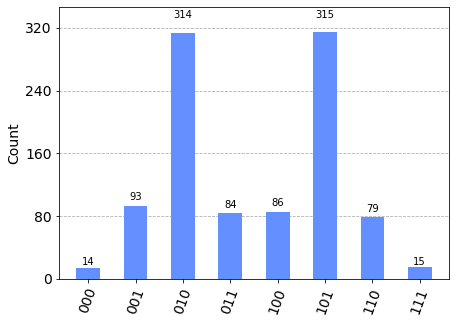

In [16]:
qc_res = get_circuit(graph, result.x[0], result.x[1])
counts = execute(qc_res, Aer.get_backend('qasm_simulator'), shots=1000).result().get_counts()
plot_histogram(counts)
#CAPTION Visualizing the final circuit

## Using Qiskit


In [17]:
import pandas as pd
import networkx as nx
from qiskit_optimization.applications import Maxcut
from qiskit.utils import QuantumInstance
from qiskit import Aer

data = pd.read_csv('./data/hero-network.csv')

heroes = {
    'MEDUSA/MEDUSALITH AM',
    'ARCLIGHT/PHILLIPA SO',
    'WOLVERINE/LOGAN ',
    'SCARLET WITCH/WANDA ',
    'ARAGORN',
    'OVERMIND/GROM',
    'BATTLEAXE/',
    'ION/',
    'PINK PEARL/'
}
#CAPTION Formulating the problem, part 1

In [18]:
relations = data[(data.hero1.isin(heroes)) & (data.hero2.isin(heroes))]
relations = pd.DataFrame(np.sort(relations.values, axis=1), columns=relations.columns).drop_duplicates(subset=['hero1', 'hero2'])

graph = nx.from_pandas_edgelist(relations, source='hero1', target='hero2')
matrix = nx.to_pandas_adjacency(graph, dtype=int)
adjacency = matrix.to_numpy()

max_cut = Maxcut(adjacency)

qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()

backend = Aer.get_backend("statevector_simulator")

quantum_instance = QuantumInstance(backend)
#CAPTION Formulating the problem, part 2

In [19]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

qaoa = QAOA(quantum_instance=quantum_instance)

# create minimum eigen optimizer based on qaoa
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

# solve quadratic program
qaoa_optimizer.solve(qp)
#CAPTION The Qiskit QAOA implementation

<MinimumEigenOptimizationResult: fval=9.0, x_0=1.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0, x_8=0.0, status=SUCCESS>